In [ ]:

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix
from keras.utils import np_utils
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
#!wget https://downloads.tatoeba.org/exports/sentences.csv

--2021-03-07 14:46:07--  https://downloads.tatoeba.org/exports/sentences.csv
Resolving downloads.tatoeba.org (downloads.tatoeba.org)... 94.130.77.194
Connecting to downloads.tatoeba.org (downloads.tatoeba.org)|94.130.77.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 513713486 (490M) [application/octet-stream]
Saving to: ‘sentences.csv’

sentences.csv       100%[===================>] 489.92M  19.9MB/s    in 26s     

2021-03-07 14:46:33 (19.0 MB/s) - ‘sentences.csv’ saved [513713486/513713486]



In [ ]:

#Google Colab 
data = pd.read_csv('/content/sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])

"""
#Jupyter
data = pd.read_csv('sentences.csv',
                            sep='\t', 
                            encoding='utf8', 
                            index_col=0,
                            names=['lang','text'])
"""

#Filter by text length
len_cond = [True if len(s)<=200 else False for s in data['text']]
data = data[len_cond]

#Filter by text language
lang = ['mkd','cmn','mar','lit','ces']
data = data[data['lang'].isin(lang)]

#Select 50000 rows for each language
data_trim = pd.DataFrame(columns=['lang','text'])

for l in lang:
    lang_trim = data[data['lang'] ==l].sample(40000,random_state = 100)
    data_trim = data_trim.append(lang_trim)

#Create a random train, valid, test split
data_shuffle = data_trim.sample(frac=1)

size = int(len(data_shuffle)*0.1)
train = data_shuffle[0:(size*7)]
valid = data_shuffle[(size*7):(size*9)]
test = data_shuffle[(size*9):]

In [ ]:
def get_trigrams(corpus,n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    
    #fit the n-gram model
    vectorizer = CountVectorizer(analyzer='char',
                            ngram_range=(3, 3)
                            ,max_features=n_feat)
    
    X = vectorizer.fit_transform(corpus)
    
    #Get model feature names
    feature_names = vectorizer.get_feature_names()
    
    return feature_names

In [ ]:

#obtain trigrams from each language
features = {}
features_set = set()

for l in lang:
    
    #get corpus filtered by language
    corpus = train[train.lang==l]['text']
    
    #get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)
    
    #add to dict and set
    features[l] = trigrams 
    features_set.update(trigrams)

    
#create vocabulary list using feature set
vocab = dict()
for i,f in enumerate(features_set):
    vocab[f]=i

In [ ]:

#train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer='char',
                             ngram_range=(3, 3),
                            vocabulary=vocab)

#create feature matrix for training set
corpus = train['text']   
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()

train_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)

In [ ]:

#Scale feature matrix 
train_min = train_feat.min()
train_max = train_feat.max()
train_feat = (train_feat - train_min)/(train_max-train_min)

#Add target variable 
train_feat['lang'] = list(train['lang'])

In [ ]:

#create feature matrix for validation set
corpus = valid['text']   
X = vectorizer.fit_transform(corpus)

valid_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
valid_feat = (valid_feat - train_min)/(train_max-train_min)
valid_feat['lang'] = list(valid['lang'])

#create feature matrix for test set
corpus = test['text']   
X = vectorizer.fit_transform(corpus)

test_feat = pd.DataFrame(data=X.toarray(),columns=feature_names)
test_feat = (test_feat - train_min)/(train_max-train_min)
test_feat['lang'] = list(test['lang'])

In [ ]:
#Fit encoder
encoder = LabelEncoder()
encoder.fit(['mkd','cmn','mar','lit','ces'])

def encode(y):
    """
    Returns a list of one hot encodings
    Params
    ---------
        y: list of language labels
    """
    
    y_encoded = encoder.transform(y)
    y_dummy = np_utils.to_categorical(y_encoded)
    
    return y_dummy

In [ ]:
#Get training data
x = train_feat.drop('lang',axis=1)
y = encode(train_feat['lang'])

#Define model
model = keras.Sequential()
model.add(layers.Dense(500, input_dim=967, activation='relu'))
model.add(layers.Dense(500, activation='relu'))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#Train model
model.fit(x, y, epochs=4, batch_size=100)

Epoch 1/4
1400/1400 [==============================] - 20s 14ms/step - loss: 0.1520 - accuracy: 0.9501
Epoch 2/4
1400/1400 [==============================] - 20s 14ms/step - loss: 0.0421 - accuracy: 0.9909
Epoch 3/4
1400/1400 [==============================] - 20s 14ms/step - loss: 0.0398 - accuracy: 0.9914
Epoch 4/4
1400/1400 [==============================] - 20s 14ms/step - loss: 0.0355 - accuracy: 0.9925


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0.9899


Text(58.5, 0.5, 'Actual')

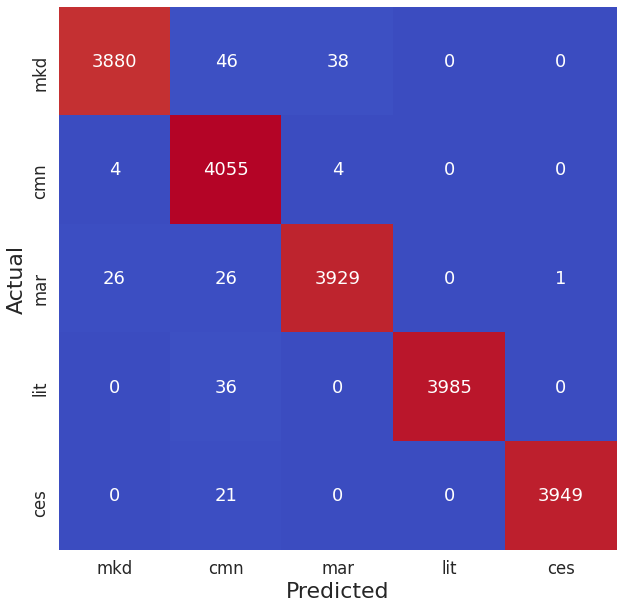

In [ ]:
x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']

#Get predictions on test set
labels = model.predict_classes(x_test)
predictions = encoder.inverse_transform(labels)

#Accuracy on test set
accuracy = accuracy_score(y_test,predictions)
print(accuracy)

#Create confusion matrix
lang = ['mkd','cmn','mar','lit','ces']
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)